In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct

from scipy.io import wavfile




def read_arduino(ser,inputBufferSize):
#     data = ser.readline((inputBufferSize+1)*2)
    data = ser.read((inputBufferSize+1)*2)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return np.flip(np.array(result)-512)



# ser.read works by waiting for <inputBufferSize> bytes from the port

def read_arduinbro(wav_array, inputBufferSize, k):
#    data = ser.readline(inputBufferSize)
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)




In [2]:
from numpy.fft import fft, ifft


In [3]:
# Load in all training data


import os

path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Eye Data/"

files = os.listdir(path)


waves = {}
labels = {}

for file in files:
    if file[-4::] == ".wav":
        samprate, wav_array = wavfile.read(path+file)
        print(samprate)
        waves[file[:-4]] = wav_array
    elif file[-4::] == ".txt":
        labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)
        labels_dat.columns = ["label", "time"]
        # Change depending on whether L is coded as 1 or as 2
        labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]
        
        labels[file[:-4].replace(".", "")] = labels_dat
        

print(waves.keys(), labels.keys())


assert set(waves.keys()).difference(set(labels.keys())) == set()



10000
10000
10000
dict_keys(['left-middle-right', 'left-middle-right2', 'left-right']) dict_keys(['left-right', 'left-middle-right', 'left-middle-right2'])


<ipython-input-3-f8928ad2d54f>:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [4]:
def plot_labelled_wave(wav_array, labels_dat, ax, i, title="", before_buffer = 0.7, after_buffer = 1, shade_alpha=0.2, wave_alpha=1):
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool



    ax[i].plot(time_seq, wav_array, alpha=wave_alpha)

    ax[i].fill_between(time_seq, 2500, -2500,
                     where = left_events_bool,
                     color = 'g',
                     alpha=shade_alpha)

    ax[i].fill_between(time_seq, 2500, -2500,
                     where = right_events_bool,
                     color = 'r',
                     alpha=shade_alpha)
    
    ax[i].set_title(key)
    

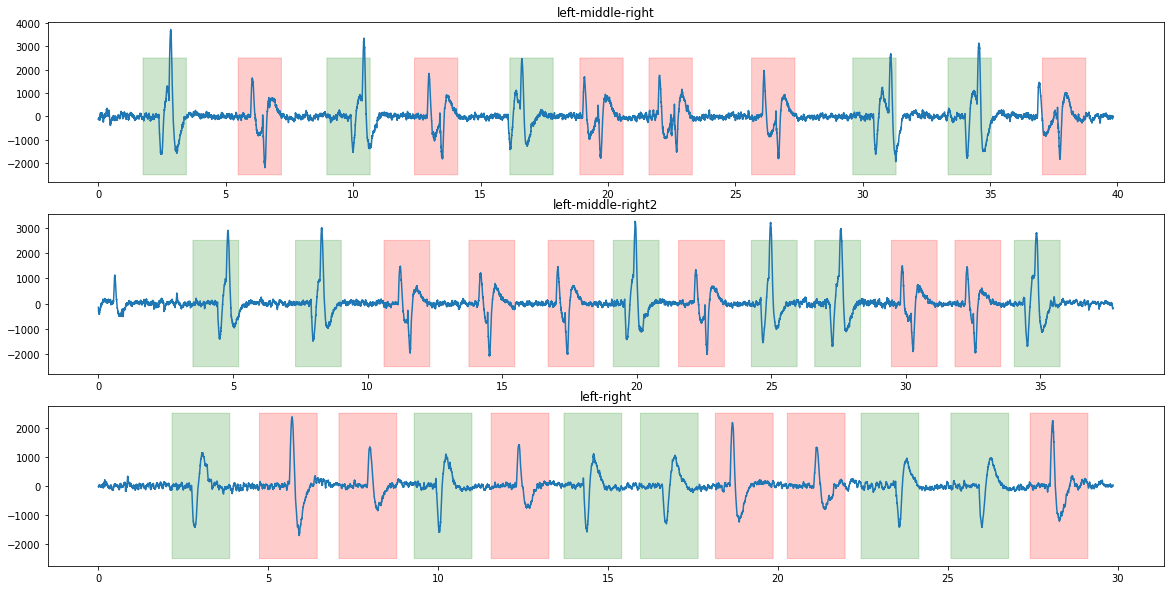

In [5]:
fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches((20, 10))

i=0
for key in waves.keys():
    
    wav_array = waves[key]
    labels_dat = labels[key]
    
    plot_labelled_wave(wav_array, labels_dat, ax, i, title=key)
    
    i+=1
    


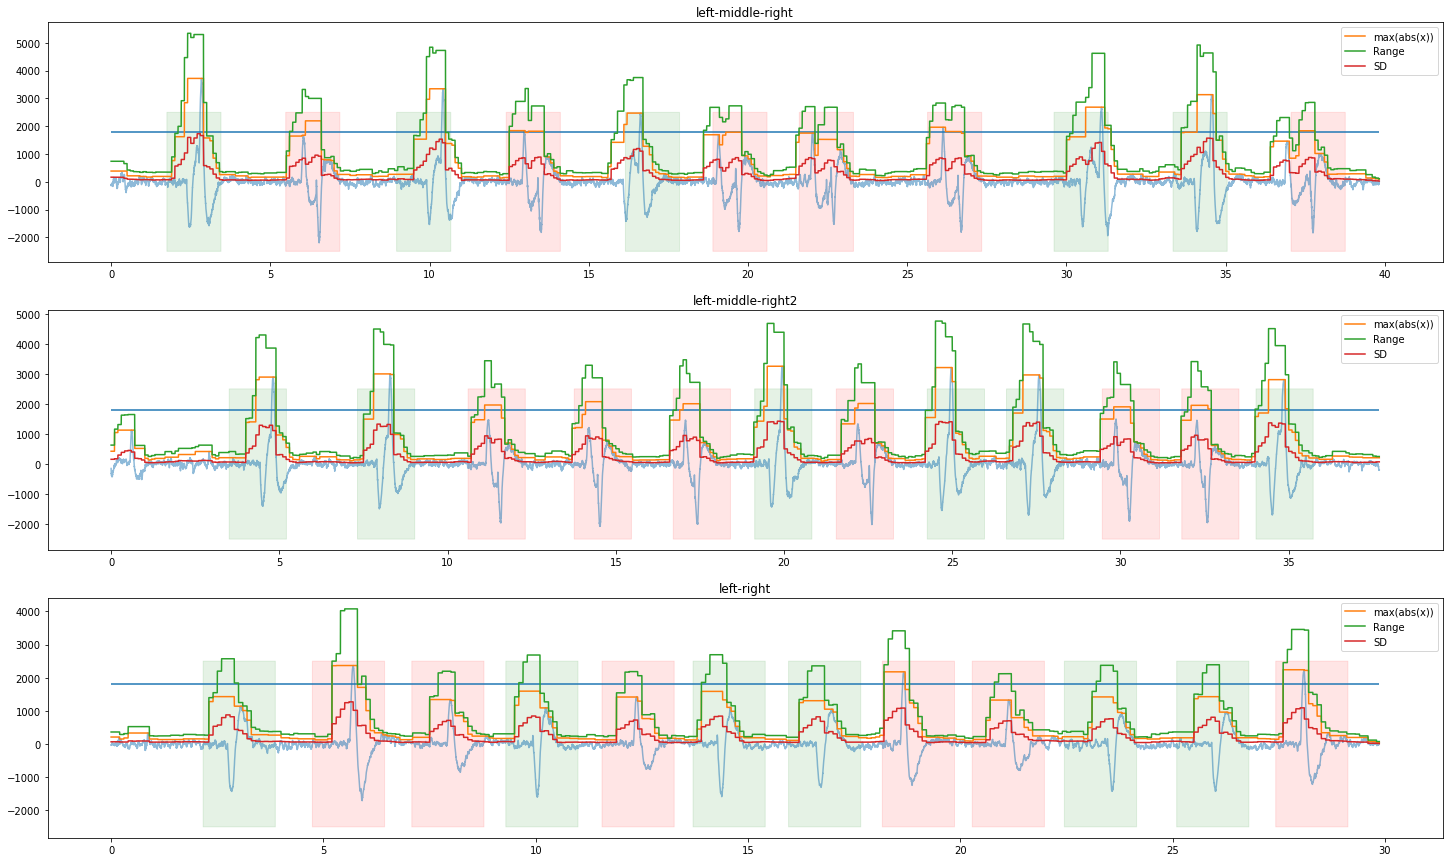

In [8]:

fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches((25, 15))

i=0
for key in waves.keys():
    
    wav_array = waves[key]
    labels_dat = labels[key]
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    
    plot_labelled_wave(wav_array, labels_dat, ax, i, title=key, wave_alpha=0.5, shade_alpha=0.1)

    
    
    index = 0
    step = int(0.1*samprate)
    window = int(0.5*samprate)
    test_stat_absmax = np.array([None]*len(wav_array))
    test_stat_zerocrossings = np.array([None]*len(wav_array))
    test_stat_max_change = np.array([None]*len(wav_array))
    test_stat_range = np.array([None]*len(wav_array))
    test_stat_sd = np.array([None]*len(wav_array))

    while index + 1 < len(wav_array):
        subset = wav_array[index:(index+window)]

        test_stat_absmax[index:index+step] = np.max(np.abs(subset))
        test_stat_zerocrossings[index:index+step] = np.sum(subset[0:-1] * subset[1::] <= 0)
        test_stat_max_change[index:index+step] = np.max(np.abs(np.diff(subset)))
        test_stat_range[index:index+step] = np.max(subset) - np.min(subset)
        
        test_stat_sd[index:index+step] = np.std(subset)
        index += step

    ax[i].plot(time_seq, test_stat_absmax, label="max(abs(x))")
#     ax[i].plot(time_seq, test_stat_zerocrossings, label="zero_crossings")
#     ax[i].plot(time_seq, test_stat_max_change*100, label="max change")
    ax[i].plot(time_seq, test_stat_range, label="Range")
    ax[i].plot(time_seq, test_stat_sd, label="SD")
    ax[i].hlines(1800, time_seq[0], time_seq[-1])
    ax[i].legend()
    
    i+=1





In [ ]:
# Threshold: range > 1800 